<a href="https://colab.research.google.com/github/MaxHuerlimann/AdaIN-Style-tf2/blob/master/AdaIN_Tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Tensorflow implementation of *AdaIN-Style* network

In [0]:
import os
from pathlib import Path
from PIL import Image

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

In [2]:
%tensorflow_version 2.x
import tensorflow as tf

from tensorflow.python.keras.preprocessing import image as kp_image
from tensorflow.python.keras import models 
from tensorflow.python.keras import losses
from tensorflow.python.keras import layers
from tensorflow.python.keras import backend as K

TensorFlow 2.x selected.


Setup Datasets

Get kaggle configurations

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp /content/gdrive/'My Drive'/Kaggle/kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json  # set permission
drive.flush_and_unmount()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
     |████████████████████████████████| 122kB 4.7MB/s 
ERROR: tensor2tensor 1.14.1 has requirement tensorflow-probability==0.7.0, but you'll have tensorflow-probability 0.9.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement google-auth~=1.7.2, but you'll have google-auth 1.11.2 which is incompatible.
ERROR: google-colab 1.0.0 has requirement requests~=2.21.0, but you'll have requests 2.23.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement six~=1.12.0, but you'll have six 1.14.0 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
kaggle.json


Download the data from kaggle

In [0]:
!ls /content/data/train_images/train_1

In [0]:
img_dir = Path('/content/data/train_images')
data_package = 'train_1'
if not os.path.exists(img_dir):
  os.makedirs(img_dir)
!kaggle competitions download painter-by-numbers -f {data_package}.zip -p {img_dir.as_posix()}

In [6]:
!unzip -q {(img_dir / data_package).as_posix()} -d {img_dir.as_posix()}

[/content/data/train_images/train_1.zip]
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of /content/data/train_images/train_1 or
        /content/data/train_images/train_1.zip, and cannot find /content/data/train_images/train_1.ZIP, period.


In [0]:
!rm {img_dir.as_posix()}/*.zip

Visualize Images

In [0]:
def load_img(path_to_img):
  max_dim = 512
  img = Image.open(path_to_img)
  long = max(img.size)
  scale = max_dim/long
  img = img.resize((round(img.size[0]*scale), round(img.size[1]*scale)), Image.ANTIALIAS)
  
  img = kp_image.img_to_array(img)
  
  # We need to broadcast the image array such that it has a batch dimension 
  img = np.expand_dims(img, axis=0)
  return img

In [0]:
  def imshow(img, title=None):
    # Remove the batch dimension
    out = np.squeeze(img, axis=0)
    # Normalize for display 
    out = out.astype('uint8')
    plt.imshow(out)
    if title is not None:
      plt.title(title)
    plt.imshow(out)

In [0]:
content_path = img_dir / data_package / '1008.jpg'
style_path = img_dir / data_package / '1007.jpg'

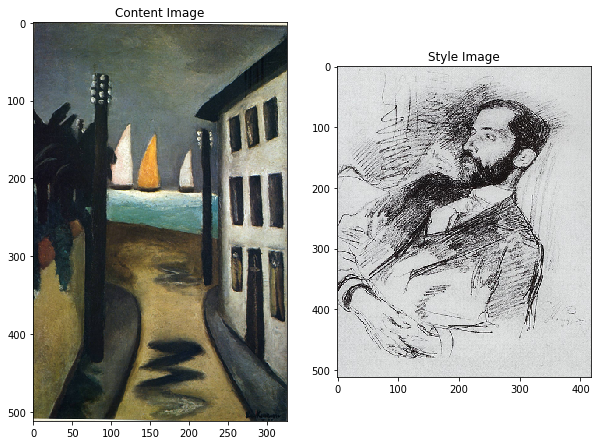

In [34]:
plt.figure(figsize=(10,10))

content = load_img(content_path.as_posix()).astype('uint8')
style = load_img(style_path.as_posix()).astype('uint8')

plt.subplot(1, 2, 1)
imshow(content, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style, 'Style Image')
plt.show()  

Data Preprocessing

In [0]:
def load_and_process_img(path_to_img):
  """Load the image and preprocess according to trained VGG19 model standards.
  """
  img = load_img(path_to_img)
  img = tf.keras.applications.vgg19.preprocess_input(img)
  return img

Create tensorflow Dataset

In [0]:
dataset = tf.data.Dataset.list_files(str(img_dir / data_package / '*'))

Model definition

In [30]:
for f in dataset.take(5):
  print(load_and_process_img(f.numpy()))

[[[[  8.060997   53.221      70.32     ]
   [-30.939003   15.221001   32.32     ]
   [-18.939003   28.221      45.32     ]
   ...
   [-21.939003   25.221      21.32     ]
   [-25.939003   13.221001    7.3199997]
   [ 16.060997   43.221      37.32     ]]

  [[-17.939003   31.221      41.32     ]
   [-28.939003   19.221      29.32     ]
   [-23.939003   24.221      34.32     ]
   ...
   [-13.939003   33.221      30.32     ]
   [-16.939003   22.221      16.32     ]
   [ 19.060997   47.221      39.32     ]]

  [[-44.939003    9.221001    8.32     ]
   [-31.939003   22.221      21.32     ]
   [-62.939003   -7.7789993  -8.68     ]
   ...
   [  2.060997   49.221      46.32     ]
   [ -1.939003   38.221      32.32     ]
   [ 21.060997   50.221      43.32     ]]

  ...

  [[  6.060997   57.221      81.32     ]
   [-60.939003   -1.7789993  26.32     ]
   [-84.939     -16.779      20.32     ]
   ...
   [-37.939003   20.221      81.32     ]
   [-42.939003   16.221      74.32     ]
   [-60.939003  

In [0]:
# Content layer where will pull our feature maps
content_layers = ['block5_conv2'] 

# Style layer we are interested in
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1'
               ]

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [0]:
def get_model():
  """ Creates our model with access to intermediate layers. 
  
  This function will load the VGG19 model and access the intermediate layers. 
  These layers will then be used to create a new model that will take input image
  and return the outputs from these intermediate layers from the VGG model. 
  
  Returns:
    returns a keras model that takes image inputs and outputs the style and 
      content intermediate layers. 
  """
  # Load our model. We load pretrained VGG, trained on imagenet data
  vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False
  # Get output layers corresponding to style and content layers 
  style_outputs = [vgg.get_layer(name).output for name in style_layers]
  content_outputs = [vgg.get_layer(name).output for name in content_layers]
  model_outputs = style_outputs + content_outputs
  # Build model 
  return models.Model(vgg.input, model_outputs)

In [0]:
model

Training

Evalutation